In [ ]:
# IMPORTANT: For this cell and the next cell, only run ONE of them.
# If this notebook is run in isolation with the rest of the project, run THIS cell.
# If this notebook is run from the project in the notebooks directory (as intended), run the NEXT cell for quick local testing.
# Install your library here, for example the fynesse template
# is set up to be pip installable
%pip install git+https://github.com/jeffrey-22/ads.git
import os, fynesse
# 2 min

In [5]:
# Import local fynesse module.
# Do NOT run this cell if the notebook is not run from the repo - this is a quick hack for local runs
# See more information in the cell above this one
%load_ext autoreload
%autoreload 2
import os, sys, IPython
from pathlib import Path
try:
    notebook_path = Path(IPython.get_ipython().run_line_magic('pwd', '')).as_posix()
except AttributeError:
    notebook_path = Path(__file__).resolve().as_posix()
script_path = os.path.abspath(notebook_path)
project_path = os.path.abspath(os.path.join(script_path, '..'))
sys.path.append(project_path)
import fynesse

d:\Projects\ads\fynesse\assess.py:68: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn).drop('db_id', axis=1, errors='ignore')


The schema stores price transaction data about the traded households.
- ```transaction_unique_identifier``` and ```db_id``` are indices for transactions and for our database respectively.
- ```price``` describes, in GBP, the price of the household.
- ```postcode```, ```primary_addressable_object_name```, ```secondary_addressable_object_name```, ```street```, ```locality```, ```town_city```, ```district```, ```county``` describe the address. We will ultimately only use the postcode to find the latitude and longitude.
- ```property_type``` describes one of: Detached, Semi-detached, Terraced, Flat/maisonette, Other, indicated by the initials.
- ```new_build_flag```, ```tenure_type```, ```ppd_category_type```, ```record_status``` likely describe some categories, but they are not very helpful as we are ultimately not given these when predicting.

We will do some sanity checks and general visualisation of the data in the assess part.

In [53]:
# Get a connection the database (by getting the item in the singleton class DatabaseConnection)
# Connection details such as credentials can be found and set in the defaults.yml file
pp_database_conn = fynesse.access.DatabaseConnection.get_connection()

In [ ]:
# Write the code you need for creating the table, downloading and uploading the data here. You can use as many code blocks as you need.
# Warning: run these once when populating the database. No need to run them again just for prediction!
# 45 min
# Make a temporary directory that holds downloaded data.
os.makedirs("tmp_data", exist_ok=True)
# Download all the price data
downloaded_pathnames = fynesse.access.download_price_data()
print(f"Downloaded files: {downloaded_pathnames}")
# Create the database remotely
fynesse.access.create_pp_table(pp_database_conn)
# Upload the files to the database
fynesse.access.upload_files_to_table(pp_database_conn, downloaded_pathnames, 'pp_data')
# Finally setup the indices
fynesse.access.setup_pp_table(pp_database_conn)

In [ ]:
# Warning: run these once when populating the database. No need to run them again just for prediction!
# Do the same thing for the postcode table
fynesse.access.create_postcode_table(pp_database_conn)
# 10s
postcode_filename = fynesse.access.download_postcode_data()
# 1m
fynesse.access.upload_files_to_table(pp_database_conn, [postcode_filename], 'postcode_data')
# 1m
fynesse.access.setup_postcode_table(pp_database_conn)

In [ ]:
# Warning: run these once when populating the database. No need to run them again just for prediction!
# Do the same thing for the prices coordinates table.
# The join method I use is to join them locally with Dask - I find it to be reasonably fast on my laptop.
# Or, in general, it is probably easier to do everything locally instead of upkeeping a database, especially when the performance becomes an issue.
# I would also argue that database only really becomes a convenience when many people could be accessing and modifying the data simulataneously,
# or if the database server is crazy good, which both are not the cases here.
# But I'll give it a try here I guess just to test my knowledge.
fynesse.access.create_prices_coordinates_table(pp_database_conn)
# 20m
joined_table_pathnames = fynesse.access.join_all_tables(downloaded_pathnames, postcode_filename, overwrite=False)
# 10m
fynesse.access.upload_files_to_table(pp_database_conn, joined_table_pathnames, 'prices_coordinates_data', ignore_first_row=True)
# 9m
fynesse.access.setup_prices_coordinates_table(pp_database_conn)

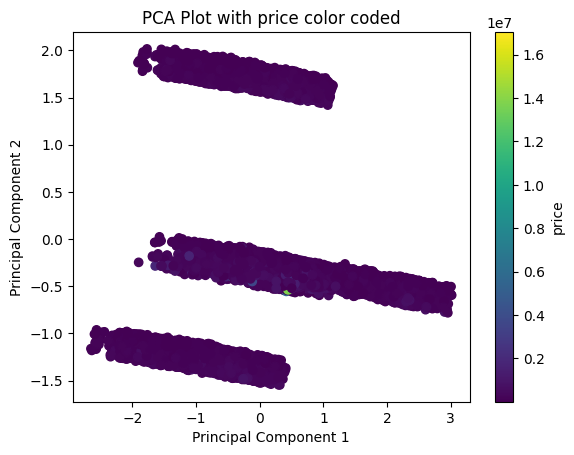

In [17]:
# Use this cell and cells below for summarising your analysis and documenting your decision making.
# I put the data sanity check in the tests (organized by pytest), here are some visualisations of the sampled data

# Here is a PCA of the features so far, i.e. all the data we've uploaded to the database.
# There are some clusters, but hard to find correlations with the prices from where they are alone.
# This is already somewhat of an indication that the final prediction result might not be very accurate...
fynesse.assess.general_PCA_plot_with_one_column_colorcoded()

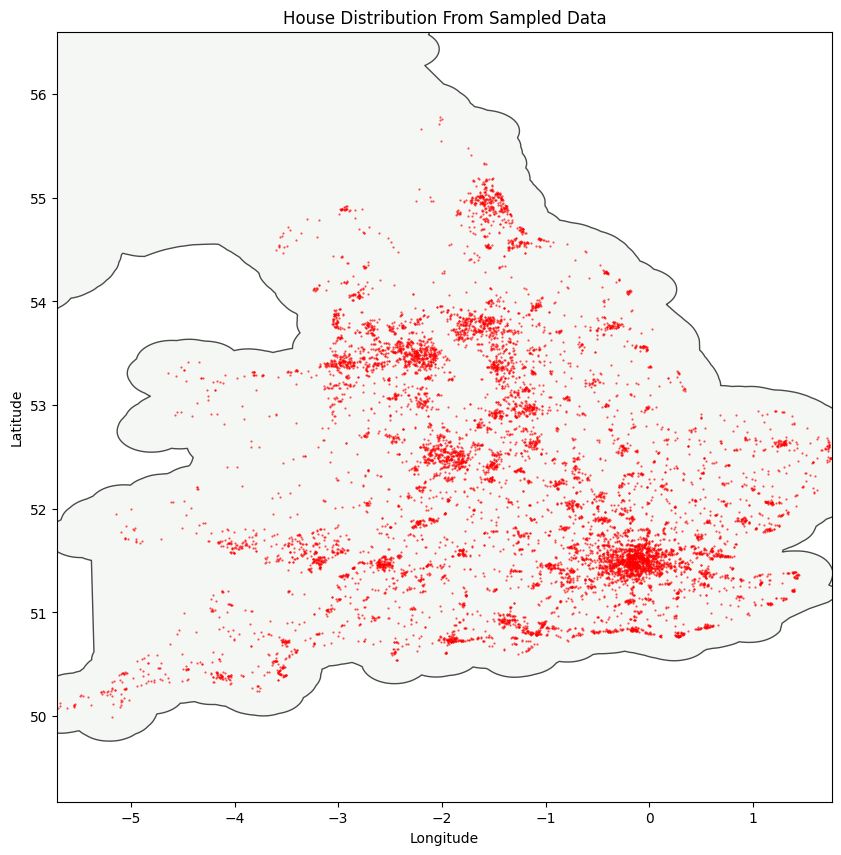

In [16]:
# Here is a plot of the house locations on a UK map. Not hard to guess that the super cluster is where London is :)
fynesse.assess.plot_general_house_distribution()

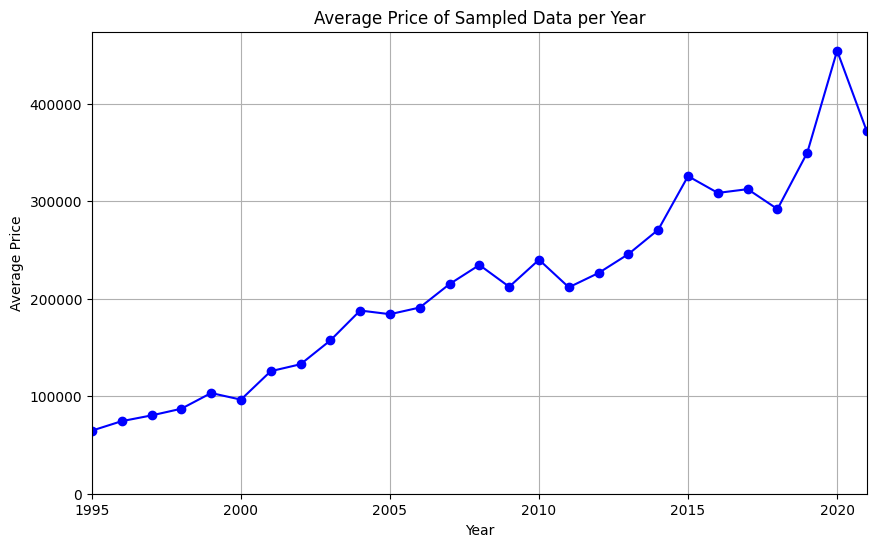

In [3]:
# Price normally increases as time goes on, so here is a plot to show that.
# There is an interesting downfall in 2021, which I assume is due to covid(?)
fynesse.assess.plot_average_house_price_against_year()

## Model decisions

The features I end up using are:
- Date, converted to number of days compared to a reference date
- Type of property, one-hot encoded
- Square root of closest euclidean distance to: school, hospital, library, restaurant, transport, shop, leisure (if none nearby the distance is -1, which means it's just a constant column that does nothing).

Reasonings for the features I include:
- Date - the economics could be related to time, so it could also relate to the price of houses. (we end up choosing a date range to predict, but the range could still be pretty big)
- Type of property - seems like a general indication of the house quality
- Distances - I would like to use actual walking distances but that sadly takes too long. Anyhow there is likely some correlation between that and the house quality. The decrease in price becomes less significant the higher the distances are, so I take the square root of the distance on top of it.

Reasonings for the features I choose not to include:
- City name, street name, etc. - Sounds like cheating. Worried the prediction might need to be verbose and account for a virtual house that does not have address data yet. Also the bounding box might already account for that.
- Other house type information (that are present in the price data) - Seems like we simply do not have access to them when making predictions.

The model is a just GLM, with a link of an identity function. The training data is chosen as all the data in a bounding box around the requested location, with a date that is within the requested date +/- 200 days. (The exact parameters are adjustable in case it takes too long to run or if hardly any data could be found)

Reasonings for the model:
- I am not really any expert at economics, so I figured a simple model should keep my sanity.
- The training data chosen in close approximity to the requested location basically entails information about the nearby area, and makes the tradeoff of having to train on the fly for having higher accuracy.

The shortcomings of the model:
- We could get negative results, but I would just say it's just bad accuracy.
- I would like to experiment more with different possibilities and their impact on accuracy, but the biggest constraint here is that most of them take way too much time to compute.
- Ultimately my "excuses" for bad results is just that the training dataset is not big and fine-tuned. But given the implementation time constraint, the computation resource limitations, and also my poor knowledge in economics, that is basically unavoidable.

d:\Projects\ads\fynesse\assess.py:225: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


==== Validation of current model, level 6 ====
No warning issued

Details of each validation level:
Level | Message
  0   | No validation
  1   | Warnings
  2   | Summary
  3   | Help message
  4   | PCA of feature array
  5   | Stratified Cross-Validation on training dataset
  6   | Area Prediction Plot
              
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  629
Model:                            GLM   Df Residuals:                      616
Model Family:                Gaussian   Df Model:                           12
Link Function:               Identity   Scale:                      6.7459e+10
Method:                          IRLS   Log-Likelihood:                -8727.9
Date:                Tue, 28 Nov 2023   Deviance:                   4.1555e+13
Time:                        23:31:47   Pearson chi2:                 4.16e+13
No. Iterations:                     3   Pseudo 

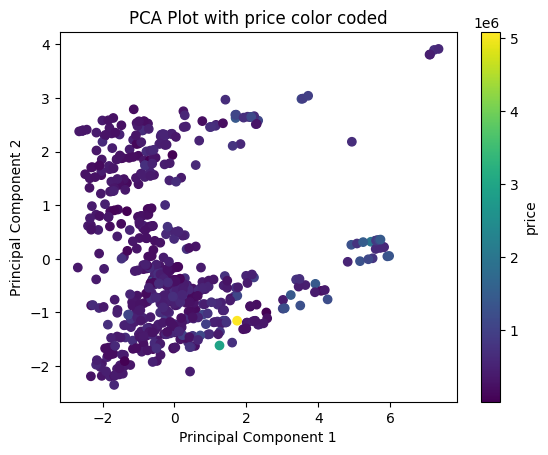

Stratified Cross-Validation on 5 folds result R^2: 0.33594969836434674

c:\Users\86189\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



==== End of Validation ====


6424751.94026991

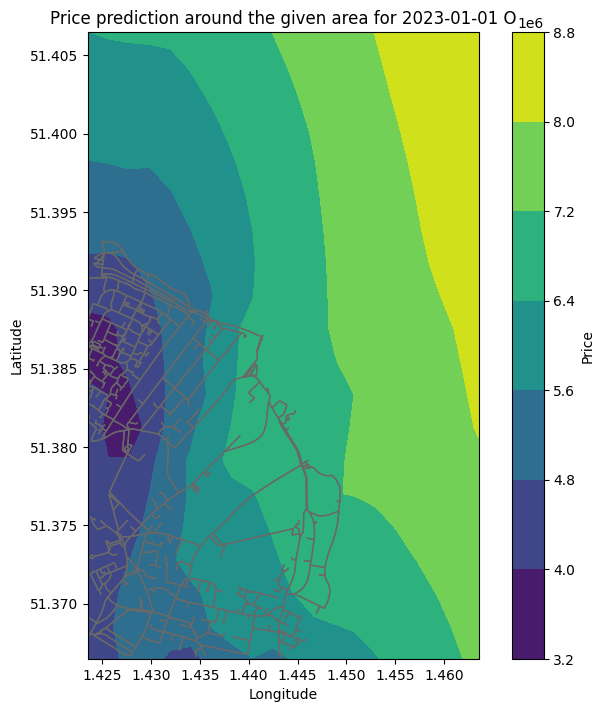

In [6]:
# Example of a prediction with some validations,
# In this example we are predicting the price of a house of type Others at (51.386, 1.444) at 2023-1-1.
# In addition to the prediction result (which is at the very end - 6424751.94026991 GBP),
# I have plotted some other information regrading the current model,
# such as a heatmap of predicted prices around that area using the model.
from datetime import date
fynesse.address.predict_price(51.3864823, 1.4435377, date(2023, 1, 1), 'O', validation_level=6)

## Large Language Models

If you used LLMs to generate or fix code in this assignment (recommended), briefly summarise the process and prompts you used. What do you think of the integration of LLMs in the data science pipeline?

I used the interactive web chat as a separate tab. I collected some of my actual prompts at the end of my thoughts.

I believe LLMs could be very helpful in the pipeline. It has managed to save me quite some time in different places, for example error debugging, basic APIs, reptitive code formatting and more. I can always just shut off my brain and toss the question out, rather than thinking of what words people are going to use when having a similar problem as mine. The simpleness, convenience and swiftness are all that matters here. If there is anything easy to be improved, it is to make them generate answers even faster.

I also want to point out some cases where LLMs end up wasting my time. At the beginning I attempted to integrate LLMs into the project using API keys (as how I did for tick 1), but the AI seems to easily get confused about the context - a lot of the times when I asked a general question, say how to use ".apply", the AI tries to make an example with the dataframe I have previous feeded them, and it takes a lot of effort to correct them. I kind of hope that the default option is have the AI forget about the context and the data every time I give a prompt, so that such nuances could be avoided.

Some of my prompts:
- access pandas series by index
- series get length
- what does -q do in pytest
- how do you specify to pytest to only fnd tests in a subdirectory
- (I copy-pasted an error I got for github action)
```
ERROR: usage: pytest [options] [file_or_dir] [file_or_dir] [...]
pytest: error: unrecognized arguments: --md=/tmp/tmp.Kp9OUO7xLo
  inifile: /home/runner/work/ads/ads/pytest.ini
  rootdir: /home/runner/work/ads/ads

Error: Process completed with exit code 4

...

=====================================================================================
Markdown summaries: https://github.com/jeffrey-22/ads/actions/runs/6989395632
=====================================================================================
```
- test that no value in a df is null or infinite

- Some other questions are answered in [this reddit forum](https://www.reddit.com/r/CST_ADS/) or [this doc](https://docs.google.com/document/d/1GfDROyUW8HVs2eyxmJzKrYGRdVyUiVXzPcDfwOO8wX0/edit?usp=sharing). Feel free to also ask about anything that comes up.